In [1]:
!ls

sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir train
!mkdir train/128

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/input/grapheme-imgs-128x128.zip' train
!cp '/content/drive/My Drive/kaggle/bengali/input/train_with_fold.csv' train

In [11]:
!ls '/content/drive/My Drive/kaggle/bengali/output/md121_v2_cutout_pl/w_kr_0.9720'*135*

'/content/drive/My Drive/kaggle/bengali/output/md121_v2_cutout_pl/w_kr_0.9720_md121_cutout_pl_eps10_offset135_sz128_bs32_do0.5_Adam_IS_fold0.h5'


In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/output/md121_v2_cutout_pl/w_kr_0.9720_md121_cutout_pl_eps10_offset135_sz128_bs32_do0.5_Adam_IS_fold0.h5' train

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/output/m_mvgg16_[2_1_1]__eps5_offset5_sz128_bs32_do0.2_Lookahead_IS_fold0.h5' train
!cp '/content/drive/My Drive/kaggle/bengali/output/w_chk_mvgg16_[2_1_1]__eps5_offset5_sz128_bs32_do0.2_Lookahead_IS_fold0.h5' train

In [0]:
!unzip -q train/grapheme-imgs-128x128.zip  -d train/128/

In [15]:
!ls train

128
grapheme-imgs-128x128.zip
train_with_fold.csv
w_kr_0.9720_md121_cutout_pl_eps10_offset135_sz128_bs32_do0.5_Adam_IS_fold0.h5


In [16]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [17]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2523457188570344735, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2073495609185566510
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7841678292515672990
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12418255440261416112
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import get_custom_objects
from sklearn.metrics import  recall_score, confusion_matrix

from tqdm.auto import tqdm
import cv2
import gc

In [0]:
train_dir='./train/128'

In [0]:
dataset_np = pd.read_csv('./train/train_with_fold.csv').to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]
fold = 0

valid_m = np.where(dataset_np[:,6]==fold)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != fold)
fold_valid_inds = np.where(dataset_np[:,6] == fold)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]


train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [0]:
def build_backbone(x_in, img_size=128):
  backbone_net = DenseNet121(include_top=False, weights=None, input_shape=(img_size, img_size, 1)) 
  x = backbone_net (x_in)
  x_avg = layers.GlobalAveragePooling2D()(x)
  x_max = layers.GlobalMaxPooling2D()(x)
  x = layers.Concatenate()([x_max, x_avg])
  x = Activation('Mish', name='mish_backbone') (x)

  return x

In [0]:
def build_head(x_in, n, name=None, drop_out=0.5):
  x = layers.BatchNormalization()(x_in)
  x = layers.Dropout(drop_out)(x)
  x = layers.Dense(512)(x)
  x = Activation('Mish', name='mish_act2_'+name) (x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(drop_out)(x)
  x = layers.Dense(n, name=name, activation='softmax')(x)
  return x

In [0]:
def build_md121_v2_model(img_size=128, drop_out=0.5):
    x_in = layers.Input(shape=(img_size, img_size, 1))
    x = build_backbone(x_in, img_size)
    out_root = build_head(x, 168,'root',drop_out=drop_out)
    out_vowel = build_head(x, 11,'vowel',drop_out=drop_out)
    out_consonant = build_head(x,7,'consonant',drop_out=drop_out)
    
    model = tf.keras.Model(inputs=x_in, outputs=[out_root, out_vowel, out_consonant])
    
    return model

In [0]:
model = build_md121_v2_model()

In [0]:
for (n, layer) in enumerate(model.layers[1].layers):
  if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
    #print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
    layer.activation = Mish(mish)
    #print('-> {}'.format(layer.activation))

In [0]:
import tempfile

def apply_modifications(model, custom_objects=None):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.
    Args:
        model: The `keras.models.Model` instance.
    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
        reference: https://github.com/raghakot/keras-vis
    """
    
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)

In [34]:
model = apply_modifications(model, custom_objects={'mish':Mish(mish)})

In [0]:
model.load_weights('./train/w_kr_0.9720_md121_cutout_pl_eps10_offset135_sz128_bs32_do0.5_Adam_IS_fold0.h5')

In [0]:
def test_batch_generator(frame, train_dir,batch_size=64):    
    
    num_imgs = len(frame)
    stats = (0.0692, 0.2051)
    
    for batch_start in range(0, num_imgs,batch_size):   
            cur_batch_size = min(num_imgs,batch_start+batch_size)-batch_start

            idx = np.arange(batch_start,batch_start+cur_batch_size)
            names_batch = frame.iloc[idx,0].values
            imgs_batch = np.zeros((cur_batch_size,128,128,1))
            
            for j in range(cur_batch_size):
                img = cv2.imread(train_dir+'/'+names_batch[j])
                img = (img.astype(np.float32)/255.0 - stats[0])/stats[1]
                imgs_batch[j,:,:,0] = img[:,:,0]

            yield imgs_batch

In [0]:
def compute_recall(frame,root_predicts,vowel_predicts,consonant_predicts):
    
    p_root=np.array([np.argmax(x) for x in root_predicts[:]]).reshape(-1)
    p_vowel = np.array([np.argmax(x) for x in vowel_predicts[:]]).reshape(-1)
    p_consonant = np.array([np.argmax(x) for x in consonant_predicts[:]]).reshape(-1)
    l = len(p_root)
    t_root=np.array(frame.iloc[:l,1].values, dtype=int)
    t_vowel=np.array(frame.iloc[:l,2].values, dtype=int)
    t_consonant=np.array(frame.iloc[:l,3].values, dtype=int)
    root_recall = recall_score(t_root, p_root, average='macro')
    vowel_recall = recall_score(t_vowel, p_vowel, average='macro')
    cons_recall = recall_score(t_consonant,p_consonant,average='macro')

    return root_recall,vowel_recall, cons_recall

In [0]:
def compute_cm(frame,root_predicts,vowel_predicts,consonant_predicts):
  p_root=np.array([np.argmax(x) for x in root_predicts[:]]).reshape(-1)
  p_vowel = np.array([np.argmax(x) for x in vowel_predicts[:]]).reshape(-1)
  p_consonant = np.array([np.argmax(x) for x in consonant_predicts[:]]).reshape(-1)
  l = len(p_root)
  t_root=np.array(frame.iloc[:l,1].values, dtype=int)
  t_vowel=np.array(frame.iloc[:l,2].values, dtype=int)
  t_consonant=np.array(frame.iloc[:l,3].values, dtype=int)
  
  vowel_cm = confusion_matrix(t_vowel, p_vowel)
  vowel_recalls = np.diag(vowel_cm / np.sum(vowel_cm, axis = 1))

  cons_cm = confusion_matrix(t_consonant,p_consonant)
  cons_recalls = np.diag(cons_cm / np.sum(cons_cm, axis = 1))

  root_cm = confusion_matrix(t_root, p_root)
  root_recalls = np.diag(root_cm / np.sum(root_cm, axis = 1))

  return root_recalls,vowel_recalls,cons_recalls

In [0]:
def get_p_dicts(model,generator):
    root_predicts,vowel_predicts, consonant_predicts = [],[],[]
    for batch_x in tqdm(generator):
        batch_predict = model.predict(batch_x)
        for j in range(batch_predict[0].shape[0]):
            root_predicts += [batch_predict[0][j]]
            vowel_predicts += [batch_predict[1][j]]
            consonant_predicts += [batch_predict[2][j]]
    return root_predicts,vowel_predicts,consonant_predicts

In [0]:
if 0: model = load_model('./train/m_md121_cw_mixup_eps10_offset50_sz128_bs32_do0.5_Lookahead_IS_fold0.h5',
                   custom_objects={'mish':Mish(mish)},
                   compile=False)

In [151]:
batch_size=512

valid_gen = test_batch_generator(valid_df,train_dir, batch_size=batch_size)
val_root_preds,val_vowel_preds,val_consonant_preds =get_p_dicts(model,valid_gen)
val_root_recall, val_vowel_recall, val_cons_recall = compute_recall(valid_df,val_root_preds,val_vowel_preds,val_consonant_preds)
val_recall = 0.5*val_root_recall+0.25*(val_vowel_recall+val_cons_recall)
print(f'valid recalls [fold{fold}]: root:{val_root_recall} vowel:{val_vowel_recall} cons:{val_cons_recall} recall:{val_recall}') 
gc.collect()


valid recalls [fold0]: root:0.9601387469103637 vowel:0.9858010649194949 cons:0.9820828061288156 recall:0.9720403412172595


7019

In [0]:
val_root_preds_corr=val_root_preds[:]

In [0]:
for i in range(len(val_root_preds)):
  if val_root_preds_corr[i][85] >0.8: val_root_preds_corr[i][62]+=0.2

In [0]:
val_root_recall_corr, _,_= compute_recall(valid_df,val_root_preds,val_vowel_preds,val_consonant_preds)

In [159]:
val_root_recall_corr

0.9601199332369238

In [156]:
val_root_recall

0.9601387469103637

-0.5999997

In [0]:
if 0: model.load_weights('./train/w_chk_md121_cw_mixup_eps10_offset50_sz128_bs32_do0.5_Lookahead_IS_fold0.h5')

In [0]:
batch_size=512

valid_gen = test_batch_generator(valid_df,train_dir, batch_size=batch_size)
val_root_preds,val_vowel_preds,val_consonant_preds =get_p_dicts(model,valid_gen)
val_root_recall, val_vowel_recall, val_cons_recall = compute_recall(valid_df,val_root_preds,val_vowel_preds,val_consonant_preds)
val_recall = 0.5*val_root_recall+0.25*(val_vowel_recall+val_cons_recall)
print(f'valid recalls [fold{fold}]: root:{val_root_recall} vowel:{val_vowel_recall} cons:{val_cons_recall} recall:{val_recall}') 
gc.collect()


valid recalls [fold0]: root:0.9503994196642348 vowel:0.9844356395086254 cons:0.9801856878332796 recall:0.9663550416675937


10469

In [0]:
val_root_recalls,val_vowel_recalls,val_cons_recalls=compute_cm(valid_df,val_root_preds,val_vowel_preds,val_consonant_preds)

In [0]:
np.where(val_root_recalls<0.90)[0]

array([ 20,  32,  54,  60,  61,  62,  63,  67,  70,  84,  85, 116, 140,
       144, 145, 152, 154, 162])

In [43]:
np.where(val_root_recalls<0.90)[0]

array([ 10,  54,  60,  61,  62,  63,  67,  84, 116, 145, 162])

In [44]:
hard_classes=np.where(val_root_recalls<0.90)[0]
light_classes=np.where(val_root_recalls>=0.9)[0]
hard_recalls=val_root_recalls[hard_classes]

for i in range(hard_classes.shape[0]):
  idx = hard_classes[i]
  print(f'{idx} {val_root_recalls[idx]}')



10 0.8214285714285714
54 0.8015873015873016
60 0.7659574468085106
61 0.7452830188679245
62 0.7055555555555556
63 0.8
67 0.875
84 0.7721518987341772
116 0.8876404494382022
145 0.8955223880597015
162 0.8095238095238095


In [45]:
np.mean(val_root_recalls[hard_classes])

0.8072409490912505

In [0]:
pred_62=np.array(np.where(np.array([np.argmax(x) for x in val_root_preds[:]])==62))

In [0]:
t_root=np.array(valid_df.iloc[:,1].values, dtype=int)

In [0]:
true_62=np.array(np.where(t_root == 62))

In [0]:
true_62_indices=np.where(valid_np[:,1]==62)

In [0]:
preds=np.array(val_root_preds[:])

In [68]:
errors_62 = [] 
for k,x in enumerate(valid_np[:]):
  pred = np.argmax(val_root_preds[k])
  max_prob = np.max(val_root_preds[k])
  true_prob = val_root_preds[k][62]
  if x[1]==62 and pred == 85: 
    print(k,x,pred,max_prob,true_prob)
    errors_62.append(x[0])

norm_62 = [] 
for k,x in enumerate(valid_np[:]):
  pred = np.argmax(val_root_preds[k])
  max_prob = np.max(val_root_preds[k])
  true_prob = val_root_preds[k][62]
  if x[1]==62 and pred == 62: 
    #print(k,x,pred,max_prob,true_prob)
    norm_62.append(x[0])

1608 ['Train_8040.png' 62 4 0 'ণ্ডু' 8040 0] 85 0.9689892 0.030115588
3864 ['Train_19322.png' 62 1 0 'ণ্ডা' 19322 0] 85 0.9681898 0.019986842
4218 ['Train_21092.png' 62 1 0 'ণ্ডা' 21092 0] 85 0.9017875 0.07981356
4297 ['Train_21485.png' 62 0 0 'ণ্ড' 21485 0] 85 0.6927662 0.2720962
4396 ['Train_21978.png' 62 2 0 'ণ্ডি' 21978 0] 85 0.9428959 0.052165173
5326 ['Train_26626.png' 62 1 0 'ণ্ডা' 26626 0] 85 0.9496181 0.046475712
7150 ['Train_35755.png' 62 1 0 'ণ্ডা' 35755 0] 85 0.8953405 0.10375187
7232 ['Train_36165.png' 62 1 0 'ণ্ডা' 36165 0] 85 0.92052025 0.024111478
9372 ['Train_46865.png' 62 4 0 'ণ্ডু' 46865 0] 85 0.91069436 0.089186065
10546 ['Train_52737.png' 62 0 0 'ণ্ড' 52737 0] 85 0.6745439 0.31848374
11012 ['Train_55057.png' 62 7 0 'ণ্ডে' 55057 0] 85 0.9718237 0.022188205
11231 ['Train_56157.png' 62 1 0 'ণ্ডা' 56157 0] 85 0.86965406 0.11915072
13311 ['Train_66554.png' 62 0 0 'ণ্ড' 66554 0] 85 0.5907122 0.3923895
15997 ['Train_79980.png' 62 1 0 'ণ্ডা' 79980 0] 85 0.5662955 0.4275405

In [73]:
errors_85=[]
for k,x in enumerate(valid_np[:]):
  pred = np.argmax(val_root_preds[k])
  max_prob = np.max(val_root_preds[k])
  true_prob = val_root_preds[k][85]
  if x[1]==85 and pred == 62: 
    print(k,x,pred,max_prob,true_prob)
    errors_85.append(x[0])

norm_85=[]
for k,x in enumerate(valid_np[:]):
  pred = np.argmax(val_root_preds[k])
  prob_pred = np.max(val_root_preds[k])
  if x[1]==85 and pred == 85: 
    #print(k,x,pred,prob_pred)
    norm_85.append(x[0])


1094 ['Train_5470.png' 85 1 0 'ন্ডা' 5470 0] 62 0.72501165 0.26194927
2158 ['Train_10784.png' 85 2 0 'ন্ডি' 10784 0] 62 0.7860236 0.20526585
3125 ['Train_15625.png' 85 2 0 'ন্ডি' 15625 0] 62 0.60173625 0.3928859
9180 ['Train_45903.png' 85 0 0 'ন্ড' 45903 0] 62 0.62698895 0.31569707
12846 ['Train_64232.png' 85 3 0 'ন্ডী' 64232 0] 62 0.64770514 0.35081142
21986 ['Train_109931.png' 85 0 0 'ন্ড' 109931 0] 62 0.891753 0.107901655
25277 ['Train_126385.png' 85 1 0 'ন্ডা' 126385 0] 62 0.7688129 0.2191942
25281 ['Train_126407.png' 85 2 0 'ন্ডি' 126407 0] 62 0.94510335 0.02553829
26766 ['Train_133832.png' 85 7 0 'ন্ডে' 133832 0] 62 0.53465545 0.051650286
29852 ['Train_149260.png' 85 2 0 'ন্ডি' 149260 0] 62 0.584039 0.38954166
32646 ['Train_163234.png' 85 2 0 'ন্ডি' 163234 0] 62 0.50959563 0.47526
33224 ['Train_166129.png' 85 3 0 'ন্ডী' 166129 0] 62 0.88623565 0.113054
39595 ['Train_197978.png' 85 1 0 'ন্ডা' 197978 0] 62 0.99239117 0.007408922


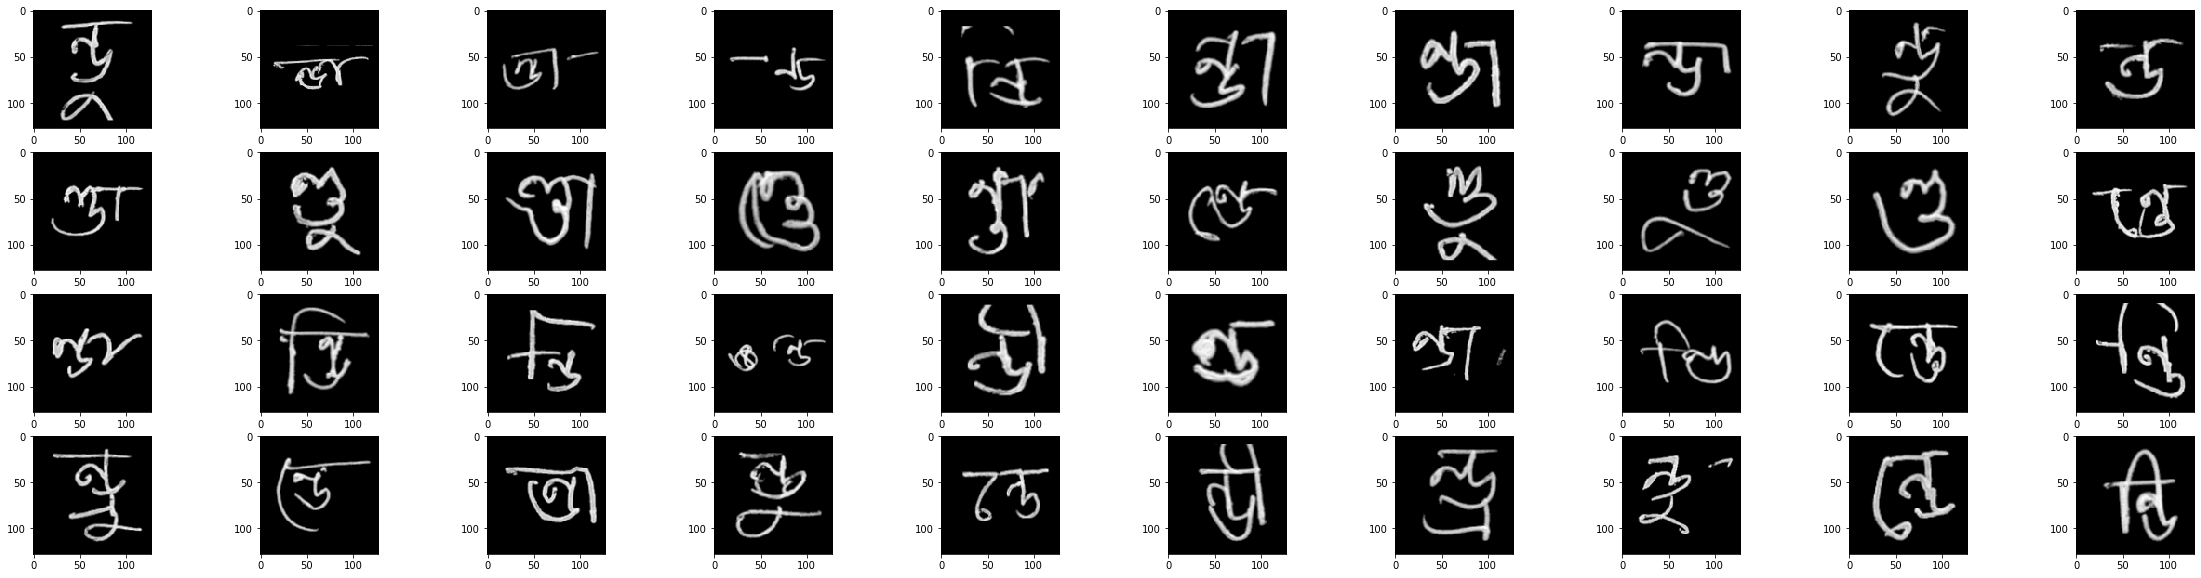

In [67]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 10, figsize=(40, 10))
for i in range(10):
  img62 = cv2.imread('./train/128/'+errors_62[i])
  img85 = cv2.imread('./train/128/'+errors_85[i])
  img62_n = cv2.imread('./train/128/'+norm_62[i])
  img85_n = cv2.imread('./train/128/'+norm_85[i])
  axs[0][i].imshow(img62)
  axs[1][i].imshow(img62_n)
  axs[2][i].imshow(img85)
  axs[3][i].imshow(img85_n)
    
plt.show()


In [56]:
errors_62[1]

'Train_5269.png'

In [49]:
train_gen = test_batch_generator(train_df,train_dir, batch_size=batch_size)
train_root_preds,train_vowel_preds,train_consonant_preds =get_p_dicts(model,train_gen)
train_recall = compute_recall(train_df,train_root_preds,train_vowel_preds,train_consonant_preds)
print(f'train recall [fold{fold}]: {train_recall}') 
gc.collect()


train recall [fold0]: (0.9906816294354279, 0.9949677174288883, 0.9930095837092389)


26960

In [54]:
0.5*train_recall[0]+0.25*(train_recall[1]+train_recall[2])

0.9923351400022458